代码学习：https://blog.csdn.net/qq_23869697/article/details/80683163
Deep Learning with TensorFlow
IBM Cognitive Class ML0120EN
Module 4 - Restricted Boltzmann Machine

# 简介
受限玻尔兹曼机是一种无监督，重构原始数据的一个简单的神经网络。
受限玻尔兹曼机先把输入转为可以表示它们的一系列输出；这些输出可以反向重构这些输入。通过前向和后向训练，训练好的网络能够提取出输入中最重要的特征。
# 为什么RBM很重要？
因为它能够自动地从输入中提取重要的特征。

# RBM有什么用
用于协同过滤(Collaborative Filtering)
降维(dimensionality reduction)
分类(classification)
特征学习(feature leatning)
主题模型(topic modeling)
搭建深度置信网络(Deep belief network)
# RBM是生成模型吗？
生成模型和判别模型的区别
判别模型: 考虑一个分类问题，如我们想根据车的一些特征分辨一辆轿车和一辆SUV。给定一个训练集，一个算法如逻辑回归，它尝试找到一条可以直线，以这条直线作为决策边界把轿车和SUV区分开。
生成模型： 根据汽车，我们可以建立一个模型，比如轿车是什么样子的；然后再根据SUV， 我们建立另外一个SUV的模型；最后根据这个两个模型，判断一辆车是轿车还是SUV.

生成模型在输入特征下有特定的概率分布。 生成模型中既可以使用监督学习和无监督：
在无监督学习中， 我们想要得到一个P(x)的模型， x是输入向量；
在监督学习中，我们首先得到的是P(x|y), y是x的标记。举个例子，如果y标记一辆车是轿车（0）或者SUV（1）， 那么p(x|y=0)就描述了轿车的特征是怎么分布的，p(x|y=1)就描述了轿车的特征是怎么分布的。 如果我们能够找到P(x|y)和P(y)， 我们就能够使用贝叶斯公式去估算P(y|x)，因为P(y|x) = P(x|y)P(y)/P(x).


# 使用MINST 数据集展示如何使用RBMs
## 初始化并加载数据
文件utils.py，这里的代码用python3。

In [9]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
#!pip install pillow
from PIL import Image
# import Image
from utils import tile_raster_images
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
mnist = input_data.read_data_sets("./MNIST_data", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting ./MNIST_data\train-images-idx3-ubyte.gz
Extracting ./MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data\t10k-labels-idx1-ubyte.gz


# RBM的层
一个RBM有两个层，第一层叫可视层(visible)或者输入层，第二层是隐藏层( hidden layer)。MNIST数据库的每一张图片有784个像素，所以可视层必须有784个输入节点。第二个隐藏层在这里设为ii个神经元。每一个神经元是2态的(binary state)， 称为si。根据jj个输入单元，并由逻辑函数(logistic function) 产生一个概率输出，决定每一个隐藏层的单元是开(si = 1)是还关(si =0)。 这里我们取	i=500
![imag1](./img/20180613220246801.png)

第一层的每一个节点有一个偏差	(bias)，使用vb表示；
第二层的每一个节点也有一个偏差，使用hb表示；

In [14]:
vb = tf.placeholder("float", [784])
hb = tf.placeholder("float", [500])

定义可视层和隐藏层之间的权重，行表示输入节点，列表示输出节点，这里权重W是一个784x500的矩阵。

In [15]:
W = tf.placeholder("float", [784, 500])

## 训练好RBM能做什么
当RBM被训练好了，它就能够在跟定一些隐藏值(如下雨)来计算一个事件（比如湿滑路面）的概率. 那就是说，RBM可以被看作是生成模型，它给每一个可能的二态向量( binary states vectors)生成一个概率。
这些二态向量( binary states vectors)多少种情况？
可视层可以有不同的二态(0或1)，或者说有不同的设置。比如，当输入层只有7个单元时，它有272 
7
  中排列，每一种排列有它对应的概率(这里我们假设没有偏差)
- (0,0,0,0,0,0,0) --> p(config1)=p(v1)=p(s1=0,s2=0, …, s7=0)
- (0,0,0,0,0,0,1) --> p(config2)=p(v2)=p(s1=0,s2=1, …, s7=1)
- (0,0,0,0,0,1,0) --> p(config3)=p(v3)=p(s1=1,s2=0, …, s7=0)
- (0,0,0,0,0,1,1) --> p(config4)=p(v4)=p(s1=1,s2=1, …, s7=1)
- etc.

所以， 如果我们有784个单元，对于全部的2^784种输入情况，它会产生一个概率分布，P(v)。

# 如何训练RBM
训练分为两个阶段：1） 前向（forward pass） 2）后向( backward pass)或者重构(reconstruction)：

## 阶段1
### 前向：
    改变的是隐藏层的值。 输入数据经过输入层的所有节点传递到隐藏层。这个计算是随机开始(This computation begins by making stochastic decisions about whether to transmit that input or not (i.e. to determine the state of each hidden layer)). 在隐藏层的节点上，X乘以W再加上h_bias. 这个结果再通过sigmoid函数产生节点的输出或者状态。因此，每个隐藏节点将有一个概率输出。对于训练集的每一行，生成一个概率构成的张量(tensor)，这个张量的大小为[1X500], 总共55000个向量[h0=55000x500]。 接着我们得到了概率的张量，从所有的分布中采样，h0。 那就是说，我们从隐藏层的概率分布中采样激活向量(activation vector). 这些得到的样本用来估算反向梯度(negative phase gradient).

In [16]:
X = tf.placeholder("float", [None, 784])
_h0= tf.nn.sigmoid(tf.matmul(X, W) + hb)  #probabilities of the hidden units
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0)))) #sample_h_given_X|

参考下面的代码理解上面的代码：

In [18]:
with  tf.Session() as sess:
    a= tf.constant([0.7, 0.1, 0.8, 0.2])
    print('a: ',sess.run(a))
    b=sess.run(tf.random_uniform(tf.shape(a)))
    print('b: ',b)
    print('a-b: ',sess.run(a-b))
    print('sign a-b: ',sess.run(tf.sign( a - b)))
    print('relu sign a-b: ',sess.run(tf.nn.relu(tf.sign( a - b))))

a:  [ 0.69999999  0.1         0.80000001  0.2       ]
b:  [ 0.2762804   0.54680908  0.44197834  0.73592496]
a-b:  [ 0.42371958 -0.44680908  0.35802168 -0.53592497]
sign a-b:  [ 1. -1.  1. -1.]
relu sign a-b:  [ 1.  0.  1.  0.]


## 阶段2
### 反向(重构)：
    RBM在可视层和隐藏层之间通过多次前向后向传播重构数据。
    所以在这个阶段，从隐藏层(h0)采样得到的激活向量作为输入。相同的权重矩阵和可视层偏差将用于计算并通过sigmoid函数。其输出是一个重构的结果，它近似原始输入。

In [20]:
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1)))) #sample_v_given_h
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

重构步骤:

从数据集中拿一个数据, 如x, 把它通过网络

Pass 0: (x) -> (x:-:_h0) -> (h0:-:v1) (v1 is reconstruction of the first pass)

Pass 1: (v1) -> (v1:-:h1) -> (_h0:-:v2) (v2 is reconstruction of the second pass)

Pass 2: (v2) -> (v2:-:h2) -> (_h1:-:v3) (v3 is reconstruction of the third pass)

Pass n: (vn) -> (vn:-:hn+1) -> (_hn:-:vn+1)(vn is reconstruction of the nth pass)

## 如何计算梯度
为了训练RBM， 我们必须使赋值到训练集V上的概率乘积最大。假如数据集V，它的每一行看做是一个可视的向量v：
![formula](./img/123.svg)
或者等效地最大化训练集概率的对数
![formulaw](./img/123.svg)

我们也可以定义一个目标函数并尝试最小化它。为了实现这个想法，我们需要这个函数的各个参数的偏导数。从上面的表达式我们知道，他们都是由权重和偏差间接组成的函数，所以最小化目标函数就是优化权重。因此，我们可以使用随机梯度下降(SGD)去找到最优的权重进而使目标函数取得最小值。在推导的时候，有两个名词，正梯度和负梯度。这两个状态反映了他们对模型概率密度的影响。正梯度取决于观测值（X），负梯度只取决于模型。
正的阶段增加训练数据的可能性；
负的阶段减少由模型生成的样本的概率。

负的阶段很难计算，所以我们用一个对比散度(Contrastive Divergence (CD))去近似它。它是按照这样的方式去设计的：梯度估计的方向至少有一些准确。实际应用中，更高准确度的方法如CD-k 或者PCD用来训练RBMs。 计算对比散度的过程中，我们要用吉布斯采样(Gibbs sampling)对模型的分布进行采样。

对比散度实际是一个用来计算和调整权重矩阵的一个矩阵。 改变权重W渐渐地变成了权重值的训练。然后在每一步(epoch)， W通过下面的公式被更新为一个新的值w’。
                            W′=W+α∗CD
                            
$ \alpha$ 是很小的步长，也就是大家所熟悉的学习率(Learning rate)

## 如何计算相对散度？
下面展示了单步相对散度的计算(CD-1)步骤:

从训练集X中取训练样本，计算隐藏层的每个单元的概率并从这个概率分布中采样得到一个隐藏层激活向量h0；
$\_h0 = sigmoid(X \otimes W + hb)$ $h0 = sampleProb(\_h0)$
2. 计算X和h0的外积，这就是正梯度
$w\_pos\_grad = X \otimes h0$ (Reconstruction in the first pass)
3. 从h重构v1， 接着对可视层单元采样，然后从这些采样得到的样本中重采样得到隐藏层激活向量h1.这就是吉布斯采样。
$\_v1=sigmoid(h0⊗transpose(W)+vb)$ $v1=sampleprob(\_v1)$(Sample v given h) $h1=sigmoid(v1⊗W+hb)$
4. 计算v1和h1的外积，这就是负梯度。
$w\_neg\_grad=v1⊗h1 $(Reconstruction 1)
5. 对比散度等于正梯度减去负梯度，对比散度矩阵的大小为784x500.
$CD = (w\_pos\_grad - w\_neg\_grad) / datapoints$
7. 更新权重为$W' = W + \alpha*CD$ 8. 最后可视层节点会保存采样的值。

## 什么是采样（sampleProb）？
在前向算法中，我们随机地设定每个hi的值为1，伴随着概率sigmoid(v⊗W+hb)sigmoid(v⊗W+hb);

在重构过程中，我们随机地设定每一个vi的值为1，伴随着概率sigmoid(h⊗transpose(W)+vb)sigmoid(h⊗transpose(W)+vb)

In [21]:
alpha = 1.0
w_pos_grad = tf.matmul(tf.transpose(X), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(X)[0])
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(X - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

## 什么是目标函数？
目的：最大限度地提高我们从该分布中获取数据的可能性
计算误差： 每一步(epoch)， 我们计算从第1步到第n步的平方误差的和，这显示了数据和重构数据的误差。

In [22]:
err = tf.reduce_mean(tf.square(X - v1))
#  tf.reduce_mean computes the mean of elements across dimensions of a tensor.

创建一个会话并初始化向量：

In [23]:
cur_w = np.zeros([784, 500], np.float32)
cur_vb = np.zeros([784], np.float32)
cur_hb = np.zeros([500], np.float32)
prv_w = np.zeros([784, 500], np.float32)
prv_vb = np.zeros([784], np.float32)
prv_hb = np.zeros([500], np.float32)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

查看第一次运行的误差：

In [26]:
sess.run(err, feed_dict={X: trX, W: prv_w, vb: prv_vb, hb: prv_hb})
# 0.48134533

0.48117787

### 整个算法的运算流程：

对于每一个epoch：

  对于每一batch：
  
     计算对比散度：
     
       对batch中的每一个数据点：
       
         w_pos_grad = 0, w_neg_grad= 0 (matrices)
         
         数据向前传播，计算v(重构)和h 
         
         更新w_neg_grad = w_neg_grad + v1 ⊗ h1
         
       对比散度=pos_grad和neg_grad的平均值除以输入数据个数
       
     更新权重和偏差 W' = W + alpha * CD
     
     计算误差
     
  重复下一epoch直到误差足够小或者在多个epoch下不再改变
         

Epoch: 0 reconstruction error: 0.063293
Epoch: 1 reconstruction error: 0.054656
Epoch: 2 reconstruction error: 0.050127
Epoch: 3 reconstruction error: 0.048532
Epoch: 4 reconstruction error: 0.046657


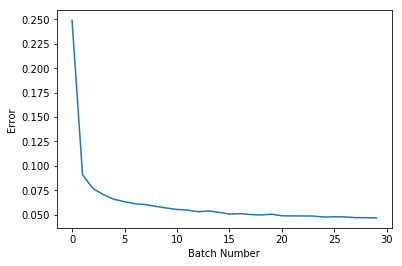

In [28]:
#Parameters
epochs = 5
batchsize = 100
weights = []
errors = []

for epoch in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={ X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={  X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={ X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
        if start % 10000 == 0:
            errors.append(sess.run(err, feed_dict={X: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
            weights.append(cur_w)
    print( 'Epoch: %d' % epoch,'reconstruction error: %f' % errors[-1])
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()

最后的权重：

In [30]:
uw = weights[-1].T
print(uw) # a weight matrix of shape (500,784)

[[-0.2400158  -0.26504162 -0.25016758 ..., -0.28525713 -0.28018212
  -0.26001319]
 [-0.24000122 -0.26500297 -0.2500048  ..., -0.28500843 -0.28000203
  -0.26000366]
 [-0.24118192 -0.26506764 -0.25182465 ..., -0.28515917 -0.28005904
  -0.26004392]
 ..., 
 [-0.24146965 -0.26509023 -0.27606919 ..., -0.2942858  -0.29007059
  -0.26002789]
 [-0.24003352 -0.26502955 -0.25002873 ..., -0.28506449 -0.28004122
  -0.26002181]
 [-0.24023111 -0.27529284 -0.25016621 ..., -0.29773638 -0.28100103
  -0.28143713]]


我们能够获得每一个隐藏的单元并可视化隐藏层和输入之间的连接。使用tile_raster_images可以帮助我们从权重或者样本中生成容易理解的图片。它把784行转为一个数组(比如25x20)，图片被重塑并像地板一样铺开。

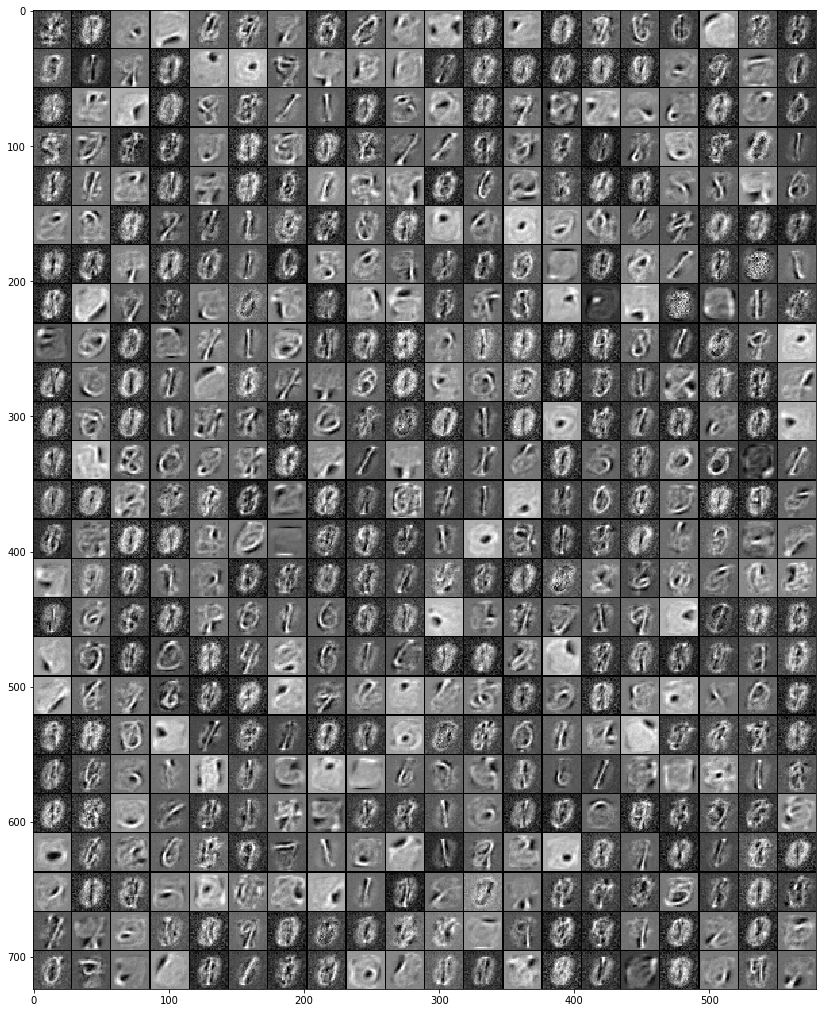

In [31]:
tile_raster_images(X=cur_w.T, img_shape=(28, 28), tile_shape=(25, 20), tile_spacing=(1, 1))
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(X=cur_w.T, img_shape=(28, 28) ,tile_shape=(25, 20), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

每一张图片表示了隐藏层和可视层单元之间连接的一个向量。

下面观察其中一个已经训练好的隐藏层单元的权重，灰色代表权重为0，越白的地方权重越大，接近1.相反得， 越黑的地方，权重越负。 权重为正的像素使隐藏层单元激活的概率，负的像素会减少隐藏层单元被激活的概率。 所以我们可以知道特定的小块(隐藏单元) 可以提取特征如果给它输入。
![pic2](./img/20180614155832667.png)

我们再看看重构得到一张图片

1)首先画出一张原始的图片

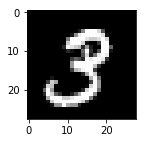

In [32]:
sample_case = trX[1:2]
img = Image.fromarray(tile_raster_images(X=sample_case, img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (2.0, 2.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray')  #you can experiment different colormaps (Greys,winter,autumn)

2) 把原始图像向下一层传播,并反向重构

In [33]:
hh0 = tf.nn.sigmoid(tf.matmul(X, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ X: sample_case, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

3)画出重构的图片

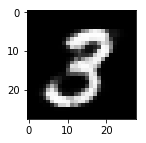

In [34]:
img = Image.fromarray(tile_raster_images(X=rec, img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (2.0, 2.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray') 

这篇文章译自 Deep Learning with TensorFlow IBM Cognitive Class ML0120EN

lab: ML0120EN-4.1-Review-RBMMNIST.ipynb